In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
import pandas as pd
# import neatplot
# neatplot.set_style()

matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [2]:
sns.set_theme()

In [3]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
process_seeds = True

In [97]:
env_name = 'Reacher'

In [98]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         #'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         #'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'BARL': 'bac_pendulum_2021-09-30/10-03-18/',
         'RQMPC': 'random_pendulum_2021-09-30/13-06-45/',
         'MPC': 'mbrl_pendulum_2021-09-30/12-16-37/',
         'PETS': 'pets_pendulum_2021-09-26/12-05-56/',
         'SAC': 'sac_pendulum_2021-09-30/12-44-00/',
         'TD3 (todo)': 'td3_pendulum_2021-09-30/15-58-49/',
         'PPO': 'ppo_pendulum_2021-09-30/15-58-55',
        }

In [99]:
cartpole_paths = {
         # 'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'BARL': 'bac_cartpole_2021-09-30/10-06-18/',
         'RQMPC': 'random_cartpole_2021-09-30/14-41-06/',
         'MPC': 'mbrl_cartpole_2021-09-30/14-23-08/',
         # 'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         'PETS': 'pets_cartpole_2021-09-26/12-17-26/',
         'SAC': 'sac_cartpole_2021-09-30/12-46-23/',
         'TD3 (todo)': 'td3_cartpole_2021-09-30/16-40-22/',
         'PPO (todo)': 'ppo_cartpole_2021-09-30/16-40-27/',         
}

In [100]:
lava_paths = {
        # 'BAC': 'bac_lava_path_2021-09-09/10-57-31/',
        'BARL': 'bac_lava_path_2021-09-25/11-47-59/',
        'RQMPC (redo this one)': 'random_lava_path_2021-09-30/22-58-35/',
        'MPC': 'mbrl_lava_path_2021-09-25/14-30-03/',
        # 'PETS (currently running)': 'pets_lava_path_2021-09-30/09-17-18/',
        # 'SAC': 'sac_lava_path_2021-09-30/12-45-03/',
        'TD3 (not there yet)': 'td3_lava_path_2021-09-16/14-18-01/',
        'PPO (also not there yet)': 'ppo_lava_path_2021-09-09/10-07-50/',
}

In [101]:
reacher_paths = {
        # 'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        # 'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        
        # 'BAC (ARD)': 'ard_reacher_bac_2021-09-18/14-59-33/',
        # 'BAC (periodic ARD)':'reacher_periodic_bac_2021-09-18/15-26-28/',
        'BAC (heavy path)': 'bac_reacher_heavy_paths_2021-09-27/09-48-01/',
        'BAC (noisy heavy path)': 'bac_reacher_noisy_heavy_path_2021-09-29/13-21-31',
        'BAC (new seeds)': 'bac_reacher_2021-09-29/10-38-12/',
        # 'Random (ARD)': 'random_reacher_2021-09-20/13-28-12/',
        'PETS': 'pets_reacher_2021-09-30/17-18-38/',
        'SAC': 'sac_reacher_2021-09-30/17-29-38/',
        # 'TD3': '',
        'PPO': 'ppo_reacher_2021-09-30/19-36-17/',
}

In [102]:
beta_tracking_paths = {
        'BARL': 'bac_beta_tracking_2021-09-25/12-14-51/',
        'RQMPC': 'random_beta_tracking_2021-09-25/14-08-07/',
        'MPC': 'mbrl_beta_tracking_2021-09-25/13-57-02/',
        'PETS (redo)': 'pets_beta_tracking_2021-09-22/18-51-05/',
        'SAC (redo)': 'sac_beta_tracking_2021-09-23/09-27-24/',
        'TD3 (redo)': 'td3_beta_tracking_2021-09-22/18-30-55/',
        'PPO (redo)': 'ppo_beta_tracking_2021-09-22/18-32-20/',
}

In [103]:
reacher_tight_paths = {
        #'BAC (ARD)': 'bac_reacher_tight_ard_2021-09-21/10-06-46/',
        #'Random (ARD)': 'random_reacher_tight_ard_2021-09-21/23-56-00/',
        'BAC (path sampling)': 'bac_reacher_tight_paths_2021-09-25/10-58-57/',
        'BAC (heavy hypers)': 'bac_reacher_tight_heavy_hypers_2021-09-25/10-58-04/',
        'BAC (heavy path)': 'bac_reacher_tight_heavy_paths_2021-09-26/14-38-26/',
        'PETS': 'pets_reacher_tight_2021-09-22/18-59-17/',
        'PETS': ''
        # 'SAC': 'sac_reacher_tight_2021-09-22/18-34-13/',
        # 'TD3': 'td3_reacher_tight_2021-09-22/15-24-00/',
        # 'PPO': 'ppo_reacher_tight_2021-09-22/15-25-08/',
}

In [104]:
swimmer_paths = {
        'BAC (ARD)': 'bac_swimmer_ard_2021-09-17/15-13-29/'
}

In [105]:
all_paths = {"Cartpole": cartpole_paths,
             "Pendulum": pend_paths,
             "Reacher": reacher_paths, 
             'Lava Path': lava_paths, 
             "Reacher (tight)": reacher_tight_paths,
             "Beta Tracking": beta_tracking_paths,
             'Swimmer': swimmer_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -250,
      "Cartpole": -13,
      "Reacher": -5,
      'Lava Path': -30,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      'Beta Tracking': -3}
gt_val = gt[env_name]

In [106]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data


def process_bac_seeds(path):
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "info.pkl"
        with seed_path.open('rb') as f:
            seed_data = pickle.load(f)
        seed_returns = np.vstack(seed_data['Eval Returns'])
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = seed_data['Eval ndata']
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(5)
    data['Eval Seed Returns'] = returns
    return data
            

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out


def process_baseline_seeds(path):
    if (path / f"seed_0" / "info.pkl").exists():
        return process_bac_seeds(path)
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "progress.csv"
        if not seed_path.exists():
            continue
        data_res = pd.read_csv(seed_path)
        returns.append(data_res["evaluation/Returns Mean"])
        if i == 0:
            data['Eval ndata'] = data_res['exploration/num steps total']
    if len(returns) == 0:
        return {}
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(returns.shape[0])
    data['Eval Seed Returns'] = returns
    return data

In [107]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    info_seed_path = base_path / path / 'seed_0'
    if info_seed_path.exists():
        if process_seeds:
            data[key] = process_bac_seeds(base_path / path)
        else:
            data[key] = process_bac(info_seed_path)
        print(f'found seed data for {key}')
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_seed_path = baseline_path / path /'seed_0'
    if baseline_seed_path.exists():
        if True:
            val = process_baseline_seeds(baseline_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_baseline(baseline_seed_path)
        print(f"found seed data for {key}")
        continue
    print(f"Data for {key} not found!")

BAC (heavy path)
BAC (noisy heavy path)
BAC (new seeds)
found seed data for BAC (new seeds)
PETS
found seed data for PETS
SAC
found seed data for SAC
PPO
found seed data for PPO


In [108]:
data.keys()

dict_keys(['BAC (heavy path)', 'BAC (noisy heavy path)', 'BAC (new seeds)', 'PETS', 'SAC', 'PPO'])

Text(0.5, 0.98, 'Control Performance on Reacher')

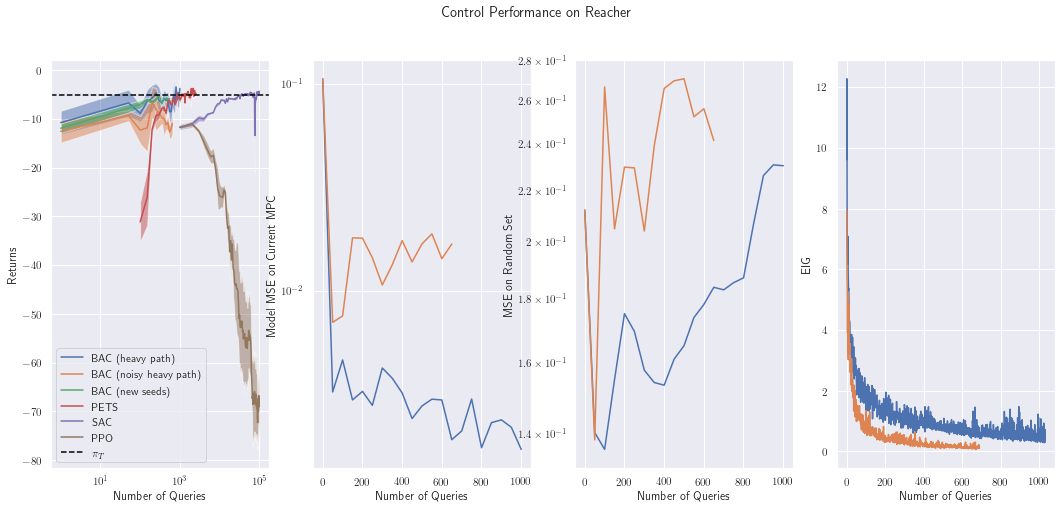

In [109]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")


Text(0.5, 0.98, 'Control Performance on Reacher')

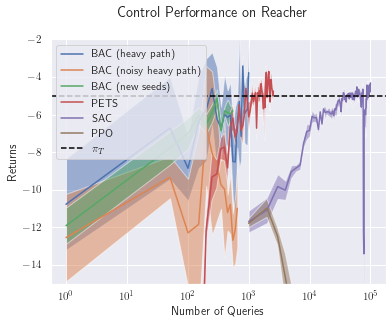

In [110]:
fig, ax = plt.subplots(figsize=(6, 4.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
if env_name == 'Lava Path':
    ax.set_ylim(-500, 0)
if env_name == 'Beta Tracking':
    ax.set_ylim(-15, 0)
if env_name == "Reacher (tight)" or env_name == "Reacher":
    ax.set_ylim(-15, -2)
ax.set_xscale('log')
# ax.set_xlim(0, 500)

fig.suptitle(f"Control Performance on {env_name}")

In [111]:
print(f"Sample complexity of algorithms on {env_name}")
for key, vals in data.items():
    if 'Eval Seed Returns' in vals:
        samps = []
        for row in vals['Eval Seed Returns']:
            try:
                sample_idx = np.where(row > gt_val)[0].min()
                samps.append(vals['Eval ndata'][sample_idx])
            except ValueError:
                samps.append(np.inf)
        print(f"{key}: {sorted(samps)}")
        continue
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    
    print(f"{key}: {sample_complexity}")

Sample complexity of algorithms on Reacher
BAC (heavy path): 251
BAC (noisy heavy path): None
BAC (new seeds): [101, 151, 251, 301, 451]
PETS: [500, 550, 700, 900, 950]
SAC: [18000, 21000, 23000, 28000, 39000]
PPO: [inf, inf, inf, inf, inf]


(-15.0, -2.0)

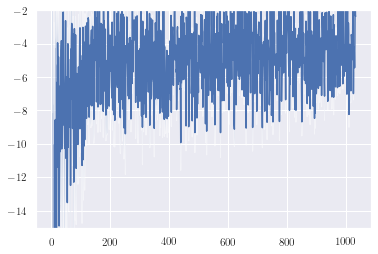

In [112]:
post_array = np.array(data['BAC (heavy path)']['Posterior Returns'])
post_mean = post_array.mean(axis=1)
post_std = post_array.std(axis=1)
plt.plot(post_mean)
plt.fill_between(range(len(post_mean)), post_mean - post_std, post_mean + post_std, alpha=0.5)
plt.ylim(-15, -2)